In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_columns = 200
import japanize_matplotlib

from time import time
import seaborn as sns
import pandas_profiling as pdp
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

from IPython.display import display
import gc

import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [43]:
train=pd.read_feather('../data/train_feat4_all.ftr')
test=pd.read_feather('../data/test_feat4_all.ftr')

In [44]:
Y_train=train.rent
X_train=train.drop(['id','rent'],axis=1)
X_test=test.drop(['id','rent','index'],axis=1)

In [45]:
category_cols=['access_1_line','access_2_line','access_1_station','access_2_station',
               'direction_enc','macro_structure','floor_info_macro_structure',
               'address_city_enc','address_town_enc','mesh_category_enc']

for col in category_cols:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

In [46]:
params = {
    'max_bin' : 63,
    'n_estimators' : 10000,
    'learning_rate': 0.01,
    'min_data_in_leaf' : 50,
    'num_leaves' : 100,
    'sparse_threshold' : 1.0,
    'device' : 'cpu',
    'save_binary': True,
    'seed' : 42,
    'feature_fraction_seed': 42,
    'bagging_seed' : 42,
    'drop_seed' : 42,
    'data_random_seed' : 42,
    'objective' : 'regression',
    'boosting_type' : 'gbdt',
    'verbose' : 0,
    'metric' : 'RMSE',
    'is_unbalance' : True,
    'boost_from_average' : False,
}

In [47]:
def rmse(y_true,y_pred):
    return np.sqrt(mean_squared_error(y_true,y_pred))

In [48]:
splits = 5
folds = KFold(n_splits=splits,shuffle=True)

categorical_features=list(X_train.columns[X_train.dtypes=='category'])

aucs = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = X_train.columns

training_start_time = time()

cv={}
y_preds = np.zeros(X_test.shape[0])

for fold_n, (trn_idx, val_idx) in enumerate(folds.split(X_train,Y_train)):
    cv_fold_start_time = time()
    print ('** Training fold {}'.format(fold_n + 1))
    X_trn, X_val = X_train.iloc[trn_idx], X_train.iloc[val_idx]
    y_trn, y_val = Y_train[trn_idx], Y_train[val_idx]
    eval_set  = [(X_trn,y_trn), (X_val, y_val)]
    
    reg = lgb.LGBMRegressor(**params)
    reg.fit(X_trn, y_trn,
            eval_set=eval_set, 
            eval_metric="rmse",
            early_stopping_rounds=100,
            categorical_feature = categorical_features,
            verbose= 500)
    
    del X_trn, y_trn
    
    val_pred=reg.predict(X_val)
    feature_importances['fold_{}'.format(fold_n + 1)] = reg.feature_importances_
    
    y_preds+=reg.predict(X_test)/splits
    del reg, X_val
    val_rmse=rmse(y_val,val_pred)
    print('RMSE accuracy: {}'.format(val_rmse))
    cv[fold_n+1]=val_rmse
    del val_pred,y_val,val_rmse

    gc.collect()
    
    cv_fold_end_time = time()
    print ('fold completed in {}s'.format(cv_fold_end_time - cv_fold_start_time))
cv=pd.DataFrame(cv,index=['cv',])
print('CV RMSE:{}'.format(cv.mean(axis=1)[0]))

** Training fold 1
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 14031.6	valid_1's rmse: 14718.4
[1000]	training's rmse: 9836.5	valid_1's rmse: 14012
[1500]	training's rmse: 7701.96	valid_1's rmse: 13920.2
Early stopping, best iteration is:
[1498]	training's rmse: 7708.31	valid_1's rmse: 13919.6
RMSE accuracy: 13919.589713761532
fold completed in 19.118294954299927s
** Training fold 2
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 13750.2	valid_1's rmse: 23944.1
[1000]	training's rmse: 9822.05	valid_1's rmse: 22282
[1500]	training's rmse: 7861.48	valid_1's rmse: 21786.2
[2000]	training's rmse: 6599.18	valid_1's rmse: 21597.9
[2500]	training's rmse: 5683.99	valid_1's rmse: 21500.3
[3000]	training's rmse: 4984.43	valid_1's rmse: 21463.2
Early stopping, best iteration is:
[2985]	training's rmse: 5002.78	valid_1's rmse: 21461
RMSE accuracy: 21460.985219086822
fold completed in 47.34524488449097s
** Training fold

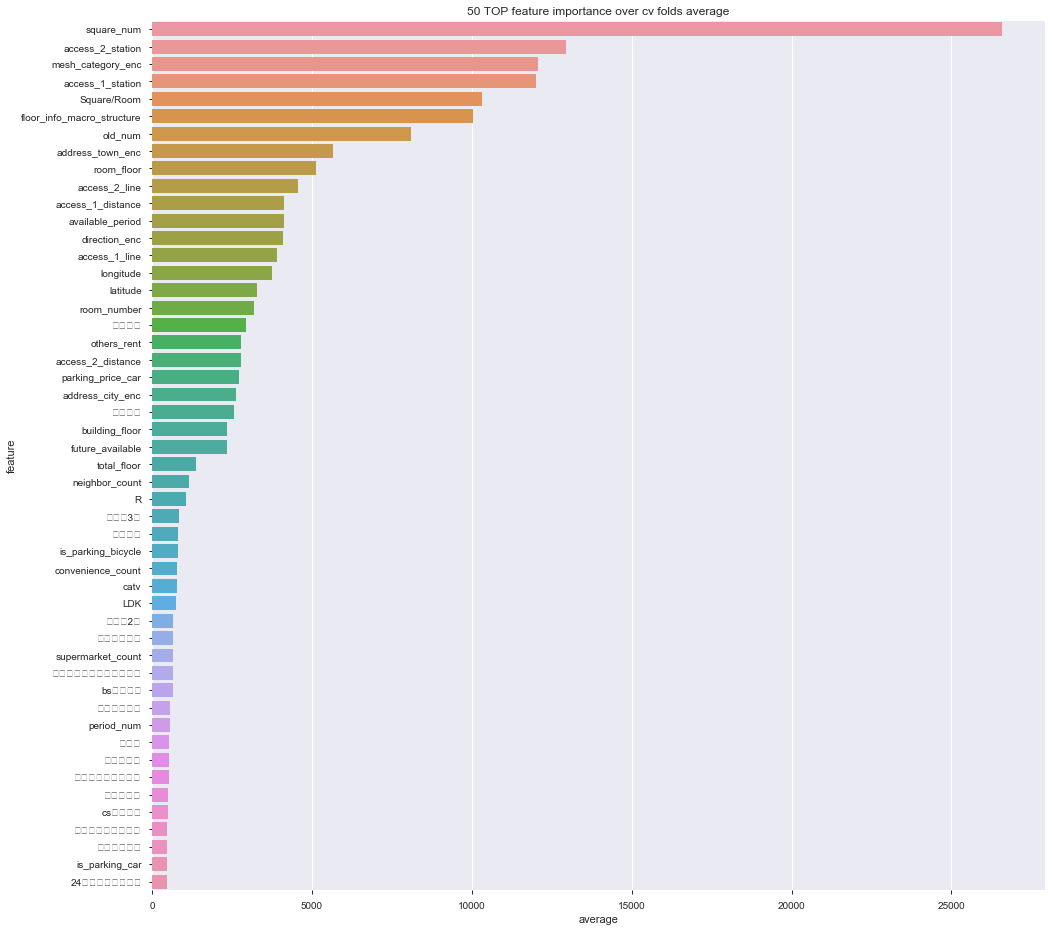

In [49]:
feature_importances['average'] = feature_importances.mean(axis=1)
feature_importances.to_feather('feat4_lighgbm_importance.ftr')
plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature')
plt.title('50 TOP feature importance over cv folds average');
plt.savefig('feat4_lighgbm_importance.png')

In [50]:
sub=pd.read_csv('../../../input/sample_submit.csv',header=None)
sub[1]=y_preds
sub.to_csv('feature4_lightgbm_CV=18412.csv',index=False,header=False)